In [21]:
import os
import sys

if os.path.abspath('../..') not in sys.path:
    sys.path.append(os.path.abspath('../..'))
    
import json
import shutil
import datetime

from dateutil.relativedelta import relativedelta
import tqdm

import scipy
import scipy.stats as st
from scipy.spatial import distance
from scipy.stats import mannwhitneyu

import numpy as np
import pandas as pd

from sqlalchemy.orm.exc import NoResultFound

from src.corpus import load_tweets
from src.dataset import load_dataset 
from src.config import config
from src.utils.backup import FileBackup
from src.dashboard.models import db, Collection, CollectionTopicProba, Document, TopicModelLoader, Topic, Subject
from src.dashboard.app import app

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

In [22]:
POSITIONS_MAP = {
    'Meteorologist': 'Meteorologist',
    'Reporter': 'Reporter',
    'Producer': 'Reporter',
    'Journalist': 'Reporter',
    'Editor': 'Reporter',
    'Other': 'Other',
    'Student': 'Other',
    'Academic': 'Other',
    'Met Producer': 'Meteorologist',
    'News Director': 'Reporter',
    'Vice President': 'Reporter', 
    'Photographer': 'Reporter'
}

In [23]:
with app.app_context():
    model_loader = None
    for model_loader in TopicModelLoader.query.all():
        if (model_loader.model.num_epochs, model_loader.model.num_topics) == (1, 6):
            break
    cs = Collection.query.all()
    data, tuples = [], []
    for c in tqdm.tqdm(cs, desc='Collecting Collection Probabilities'):
        topics = c.get_topic_dist(model_loader)
        proba_sum = 0
        for t in topics:
            proba_sum += t.proba
        if c.subject is None:
            continue
        event_id = 'None'
        event_type = 'None'
        if c.event:
            event_id = c.event.id
            event_type = c.event.event_type
        groups = c.group.split('-')
        index = 0
        try:
            index = int(groups[-1])
            group = '-'.join(groups[:-1])
        except ValueError as ex:
            group = '-'.join(groups)
        tuples += [(c.id, c.type, group, index, c.subject_id, event_id, event_type, c.subject.position)]
        data.append({topic_proba.topic.label: topic_proba.proba for i, topic_proba in enumerate(topics)})
    index = pd.MultiIndex.from_tuples(tuples, names=['id', 'type', 'group', 'index', 'subject_id', 
                                                     'event_id', 'event_type', 'position'])
    df = pd.DataFrame.from_records(data)
    df.index = index
    relevant_topics = Topic.query.filter(
        Topic.topic_model_loader_id == model_loader.id,
        Topic.is_relevant.is_(True),
    ).all()

In [127]:
meta_df = df.index.to_frame().reset_index(drop=True)[['group', 'event_type', 'position', 'subject_id', 'event_id']].drop_duplicates()

meta_df['Event Type'] = meta_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
meta_df = meta_df.assign(Position=meta_df['position'].map(POSITIONS_MAP))

meta_df = meta_df[meta_df['Position'] == 'Meteorologist']

meta_1_df = meta_df.pivot_table(index=['Event Type', 'group'], columns=['Position'], values='subject_id', aggfunc='count')

print(meta_1_df.to_latex())

meta_1_df

\begin{tabular}{llr}
\toprule
         & Position &  Meteorologist \\
Event Type & group &                \\
\midrule
Join & After &            734 \\
         & Before &            734 \\
Workshop & After &             24 \\
         & Before &             24 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_20084/1749468363.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(meta_1_df.to_latex())


Position           Meteorologist
Event Type group                
Join       After             734
           Before            734
Workshop   After              24
           Before             24

In [128]:
meta_df = df.index.to_frame().reset_index(drop=True)[['group', 'event_type', 'position', 'subject_id', 'event_id']].drop_duplicates()

meta_df['Event Type'] = meta_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
meta_df = meta_df.assign(Position=meta_df['position'].map(POSITIONS_MAP))

meta_df = meta_df[meta_df['Position'] == 'Meteorologist']

meta_1_df = meta_df.pivot_table(index=['group'], columns=['Position'], values='subject_id', aggfunc='count')

print(meta_1_df.to_latex())

meta_1_df

\begin{tabular}{lr}
\toprule
Position &  Meteorologist \\
group           &                \\
\midrule
After           &            758 \\
Before          &            758 \\
Non-Participant &            463 \\
Participant     &            813 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_20084/1318066692.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(meta_1_df.to_latex())


Position,Meteorologist
group,
After,758
Before,758
Non-Participant,463
Participant,813


In [54]:
relevant_topics_cols = ['Topic 1 - Emissions/Gas', 'Topic 2 - Energy/Cliamate/Oil/Gas']

In [55]:
def index_filter(df, **kwargs):
    filters = None
    for key, value in kwargs.items():
        item_filter = df.index.get_level_values(key) == value
        if filters is None:
            filters = item_filter
        else:
            filters = filters & item_filter
    return filters

In [56]:
def get_best_distribution(data):
    """Gets best fit distribution by performing ks-test.
    
    source-code from: https://stackoverflow.com/a/51742444/4301023
    """
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)
        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))
    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value
    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))
    return best_dist, best_p, params[best_dist]

In [69]:
data_df = df[index_filter(df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

# data_df = data_df[data_df['Position'] != 'Other']
data_df = data_df[data_df['Position'] == 'Meteorologist']

num_0 = len(data_df)

print(num_0)

# no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

# data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

assert num_0 == len(data_df)

# print(data_df.group_y.value_counts())

# data_df = data_df[data_df.group_y].drop('group_y', axis=1)

for event_type in data_df['Event Type'].unique():
    before_s = data_df[(data_df['Event Type'] == event_type) & (data_df['group'] == 'Before')]['Topic Relevance']
    after_s = data_df[(data_df['Event Type'] == event_type) & (data_df['group'] == 'After')]['Topic Relevance']
    U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
    print(U1, p)
    print(before_s.median(), after_s.median())
    

before_s = data_df[data_df['group'] == 'Before']['Topic Relevance']
after_s = data_df[data_df['group'] == 'After']['Topic Relevance']
U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
print(U1, p)
print(before_s.median(), after_s.median())

1516
299479.5 1.453710908532369e-05
0.0 0.0
279.0 0.5822382388337067
0.006037583177790849 0.029758522209431808
318139.5 2.317265302310644e-05
0.0 0.0


In [161]:
data_df = df[index_filter(df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position'] == 'Meteorologist']

no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

data_df = data_df[data_df.group_y].drop('group_y', axis=1)

columns = [('Topic Relevance', 'Before'), ('Topic Relevance', 'After')]

count_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['subject_id'], aggfunc=lambda x: len(x.unique()), margins=2)[('subject_id', 'All')]
pivot_df = data_df.pivot_table(index=['Event Type', 'Position'], columns=['group'], values=['Topic Relevance'], aggfunc='mean', margins=2)[columns]

pivot_df['\\Delta'] = (pivot_df[('Topic Relevance', 'After')] - pivot_df[('Topic Relevance', 'Before')]) * 100 / pivot_df[('Topic Relevance', 'Before')]

pivot_df = pivot_df.applymap("{0:.2f}".format)

pivot_df['Support'] = count_df.sum(axis=1)

print(pivot_df.to_latex())

count_df


Event Type  Position     
Join        Meteorologist    732
Workshop    Meteorologist     24
All                          738
Name: (subject_id, All), dtype: int64

Participant        1368
Non-Participant     463
Name: Group, dtype: int64
346476.0 0.0011825581253292175
0.1409792519770531 0.1602243973859554


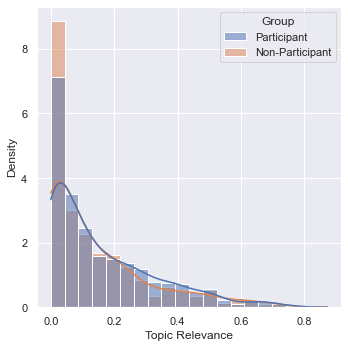

In [111]:
fig_df = df[index_filter(df, type='inter-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))

fig_df = fig_df[fig_df['event_type'] == 'None']
fig_df = fig_df[fig_df['Position'] == 'Meteorologist']

print(fig_df['Group'].value_counts())

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

sns.histplot(fig_df, x='Topic Relevance', hue='Group', bins=20, stat='density', kde=True, common_norm=False, ax=ax)
ax.set_xlabel(xlabel='Topic Relevance')

fig.tight_layout()
# plt.show()

plt.savefig('inter-subject-topic-relevance.png', bbox_inches='tight')

participant_s = fig_df[fig_df['Group'] == 'Participant']['Topic Relevance']
non_participant_s = fig_df[fig_df['Group'] == 'Non-Participant']['Topic Relevance']

U1, p = mannwhitneyu(participant_s, non_participant_s, alternative='greater')
print(U1, p)
print(non_participant_s.mean(), participant_s.mean())

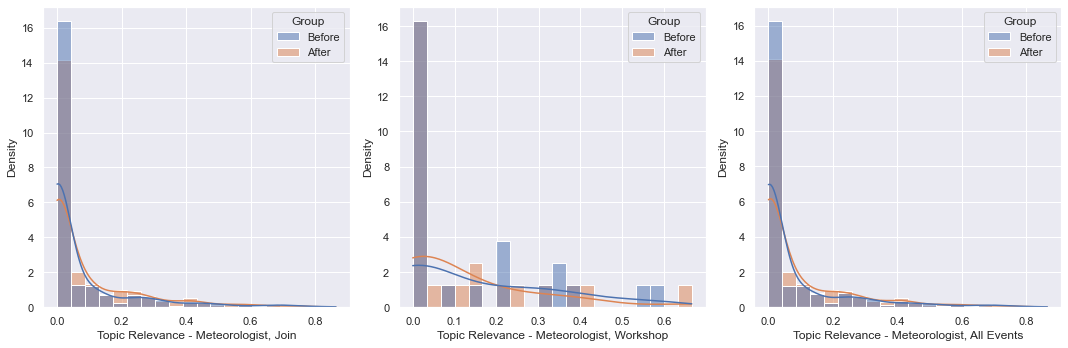

In [77]:
fig_df = df[index_filter(df, type='intra-subject')][relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])
fig_df['EventType'] = fig_df['event_type']
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist') & (fig_df['EventType'] == 'Joined')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[0])
axs[0].set_xlabel(xlabel='Topic Relevance - Meteorologist, Join')

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist') & (fig_df['EventType'] == 'Workshop')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[1])
axs[1].set_xlabel(xlabel='Topic Relevance - Meteorologist, Workshop')

sub_fig_df = fig_df[(fig_df['Position'] == 'Meteorologist')]
sns.histplot(sub_fig_df, x='Topic Relevance', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[2])
axs[2].set_xlabel(xlabel='Topic Relevance - Meteorologist, All Events')

fig.tight_layout()

# plt.show()

plt.savefig('intra-subject-topic-relevance.png', bbox_inches='tight')

60560.5 0.13463859557605873
145293.0 0.9481694844954386
1.0895735595789926 1.1659402462051434


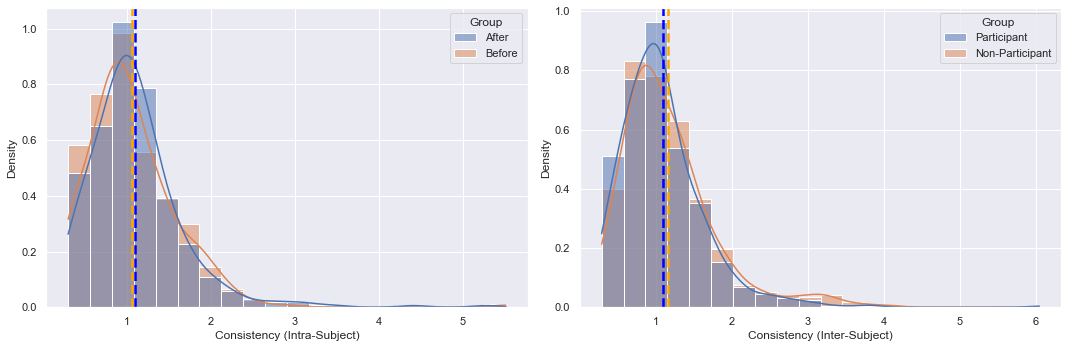

In [124]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

data_df = data_df[data_df.std(axis=1) != 0]

consistency_df = data_df.mean(axis=1) / data_df.std(axis=1)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']

sub_fig_df = sub_fig_df.assign(Position=sub_fig_df['position'].map(POSITIONS_MAP))
sub_fig_df = sub_fig_df[sub_fig_df['Position'] == 'Meteorologist']

sns.histplot(sub_fig_df, x='Consistency', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[0],
                hue_order=['After', 'Before'])
axs[0].set_xlabel(xlabel='Consistency (Intra-Subject)')

after_s = sub_fig_df[sub_fig_df['Group']=='After']['Consistency']
axs[0].axvline(x=after_s.mean(), color='blue', ls='--', lw=2.5)

before_s = sub_fig_df[sub_fig_df['Group']=='Before']['Consistency']
axs[0].axvline(x=before_s.mean(), color='orange', ls='--', lw=2.5)

U1, p = mannwhitneyu(after_s, before_s, alternative='greater')
print(U1, p)

# 

data_df = df[index_filter(df, type='inter-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

data_df = data_df[data_df.std(axis=1) != 0]

consistency_df = data_df.mean(axis=1) / data_df.std(axis=1)

sub_fig_df = consistency_df.reset_index(drop=False, name='Consistency')
sub_fig_df['Group'] = sub_fig_df['group']

sub_fig_df = sub_fig_df.assign(Position=sub_fig_df['position'].map(POSITIONS_MAP))
sub_fig_df = sub_fig_df[sub_fig_df['Position'] == 'Meteorologist']

sns.histplot(sub_fig_df, x='Consistency', bins=20, hue='Group', stat='density', kde=True, common_norm=False, ax=axs[1],
                hue_order=['Participant', 'Non-Participant'])
axs[1].set_xlabel(xlabel='Consistency (Inter-Subject)')

non_participant_s = sub_fig_df[sub_fig_df['Group']=='Non-Participant']['Consistency']
axs[1].axvline(x=non_participant_s.mean(), 
               color='orange', ls='--', lw=2.5)

participant_s = sub_fig_df[sub_fig_df['Group']=='Participant']['Consistency']
axs[1].axvline(x=participant_s.mean(), 
               color='blue', ls='--', lw=2.5)

U1, p = mannwhitneyu(participant_s, non_participant_s, alternative='greater')
print(U1, p)
print(participant_s.mean(), non_participant_s.mean())

fig.tight_layout()
plt.savefig('consistency.png', bbox_inches='tight')

In [110]:
data_df = df[index_filter(df, type='intra-subject-consistency')] \
        .loc[:, relevant_topics_cols].sum(axis=1) \
        .reset_index(name='proba') \
        .pivot_table(
            index=['type', 'group', 'subject_id', 'event_id', 'event_type', 'position'], 
            columns=['index'], 
            values='proba',
        ) \
        .dropna()

data_df = data_df[data_df.std(axis=1) != 0]

consistency_df = data_df.std(axis=1) / data_df.mean(axis=1)

data_df = consistency_df\
        .reset_index(drop=False, name='Consistency')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})

data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))
data_df = data_df[data_df['Position'] == 'Meteorologist']

count_df = data_df.pivot_table(index=['Event Type'], columns=['group'], values=['Consistency'], aggfunc='count', margins=2)[['Consistency']]
pivot_df = data_df.pivot_table(index=['Event Type'], columns=['group'], values=['Consistency'], margins=2)[['Consistency']]

pivot_df.drop(labels=[('Consistency', 'All')], axis=1, inplace=True)

pivot_df['\\Delta'] = (pivot_df[('Consistency', 'Before')]-pivot_df[('Consistency', 'After')]) * 100 / pivot_df[('Consistency', 'Before')]

pivot_df = pivot_df.applymap("{0:.2f}".format)

pivot_df['Support'] = count_df.sum(axis=1)

print(pivot_df.to_latex())

\begin{tabular}{llllr}
\toprule
{} & \multicolumn{2}{l}{Consistency} & \textbackslash Delta & Support \\
group &       After & \multicolumn{3}{l}{Before} \\
Event Type &             &        &        &         \\
\midrule
Join       &        1.16 &   1.23 &   5.53 &    1318 \\
Workshop   &        1.04 &   1.12 &   6.56 &      54 \\
All        &        1.15 &   1.22 &   5.55 &    1372 \\
\bottomrule
\end{tabular}



/var/folders/j6/3yj400mn1k1c_5czn3j_1mm00000gp/T/ipykernel_20084/1989065744.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_df.to_latex())


In [107]:
join_before_s = data_df[(data_df['Event Type'] == 'Join') & 
                        (data_df['group'] == 'Before')]['Consistency']
join_after_s = data_df[(data_df['Event Type'] == 'Join') & 
                       (data_df['group'] == 'After')]['Consistency']

U1, p = mannwhitneyu(join_after_s, join_before_s, alternative='greater')
print(U1, p)

join_before_s.mean(), join_after_s.mean()

50764.5 0.8478321915940821


(1.2255112646595911, 1.1577178448186587)

In [106]:
workshop_before_s = data_df[(data_df['Event Type'] == 'Workshop') & 
                            (data_df['group'] == 'Before')]['Consistency']
workshop_after_s = data_df[(data_df['Event Type'] == 'Workshop') & 
                           (data_df['group'] == 'After')]['Consistency']

U1, p = mannwhitneyu(workshop_after_s, workshop_before_s, alternative='greater')
print(U1, p)

workshop_before_s.mean(), workshop_after_s.mean()

83.0 0.6428034811828368


(1.115676169584127, 1.0425042933050501)

In [108]:
consistency_before_s = data_df[(data_df['group'] == 'Before')]['Consistency']
consistency_after_s = data_df[(data_df['group'] == 'After')]['Consistency']

U1, p = mannwhitneyu(consistency_after_s, consistency_before_s, alternative='greater')
print(U1, p)

consistency_before_s.mean(), consistency_after_s.mean()

54886.5 0.8648541351947061


(1.2210584905349104, 1.1532865543758275)

Total number of participants 738
Non-Participant    463
Participant        463
Name: Group, dtype: int64
U:  112739.5 , P-value:  0.08491582334351472
0.1409792519770531 0.15431251180699526


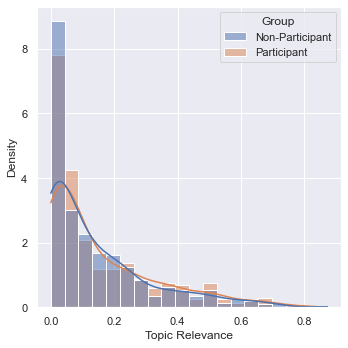

In [157]:
data_df = df[index_filter(df, type='intra-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

data_df['Event Type'] = data_df['event_type'].map({'Joined': 'Join', 'Workshop': 'Workshop'})
data_df = data_df.assign(Position=data_df['position'].map(POSITIONS_MAP))

data_df = data_df[data_df['Position'] == 'Meteorologist']

no_one_df = (data_df.groupby(['subject_id', 'event_id'])['group'].count() == 2).reset_index()

data_df = data_df.merge(no_one_df, on=['subject_id', 'event_id'], suffixes=('', '_y'))

data_df = data_df[data_df.group_y].drop('group_y', axis=1)

participant_ids_s = data_df['subject_id'].unique()

print('Total number of participants', len(participant_ids_s))

fig_df = df[index_filter(df, type='inter-subject')] \
        .loc[:, relevant_topics_cols] \
        .sum(axis=1) \
        .reset_index(drop=False, name='Topic Relevance')

fig_df = fig_df.assign(Group=fig_df['group'])
fig_df = fig_df.assign(Position=fig_df['position'].map(POSITIONS_MAP))

fig_df = fig_df[fig_df['event_type'] == 'None']
fig_df = fig_df[fig_df['Position'] == 'Meteorologist']

participants_df = fig_df[fig_df['Group'] == 'Non-Participant']

non_participants_df = fig_df[fig_df['subject_id'].isin(participant_ids_s)].sample(participants_df.shape[0])

fig_df = pd.concat([participants_df, non_participants_df], ignore_index=True)

print(fig_df['Group'].value_counts())

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

sns.histplot(fig_df, x='Topic Relevance', hue='Group', bins=20, stat='density', kde=True, common_norm=False, ax=ax)
ax.set_xlabel(xlabel='Topic Relevance')

fig.tight_layout()
plt.savefig('inter-subject-topic-relevance.png', bbox_inches='tight')

participant_s = fig_df[fig_df['Group'] == 'Participant']['Topic Relevance']
non_participant_s = fig_df[fig_df['Group'] == 'Non-Participant']['Topic Relevance']

U1, p = mannwhitneyu(participant_s, non_participant_s, alternative='greater')
print('U: ', U1, ', P-value: ', p)
print(non_participant_s.mean(), participant_s.mean())